# ESDA - Population

Goh Si Hui  
October 27, 2024

# Setting the environment

In [ ]:
pacman::p_load(tidyverse, purrr, sf, tmap, sfdep)

# Importing Datasets

## Business data

In [ ]:
respop <- read_rds("data/rds/res_coords.rds")
glimpse(respop)

Rows: 10,489
Columns: 5
$ address              <chr> "1 BEACH RD", "1 BEDOK STH AVE 1", "1 CHAI CHEE R…
$ total_dwelling_units <dbl> 142, 206, 102, 55, 96, 125, 247, 95, 220, 219, 31…
$ postal               <chr> "190001", "460001", "461001", "500001", "160001",…
$ latitude             <chr> "1.3036713506088", "1.32085208689731", "1.3279687…
$ longitude            <chr> "103.864478660925", "103.933721091441", "103.9227…

convert to sf

In [ ]:
respop_sf <- st_as_sf(respop, 
                       coords = c("longitude", "latitude"),
                       crs=4326) %>%
  st_transform(crs = 3414)

glimpse(respop_sf)

Rows: 10,489
Columns: 4
$ address              <chr> "1 BEACH RD", "1 BEDOK STH AVE 1", "1 CHAI CHEE R…
$ total_dwelling_units <dbl> 142, 206, 102, 55, 96, 125, 247, 95, 220, 219, 31…
$ postal               <chr> "190001", "460001", "461001", "500001", "160001",…
$ geometry             <POINT [m]> POINT (31467.83 31778.89), POINT (39173.81 …

In [ ]:
dwelling <- respop_sf %>%
  group_by(postal) %>%
  summarise (TOTAL_DWELLING = sum(total_dwelling_units))

## Singapore Master Plan 2019 Subzone Boundary

In [ ]:
mpsz <-st_read(dsn = "data/spatial",
               layer = "MPSZ-2019") %>% 
  st_transform(crs = 3414)

Reading layer `MPSZ-2019' from data source 
  `C:\sihuihui\mitbcapstone\notebooks\data\spatial' using driver `ESRI Shapefile'
Simple feature collection with 332 features and 6 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 103.6057 ymin: 1.158699 xmax: 104.0885 ymax: 1.470775
Geodetic CRS:  WGS 84

In [ ]:
st_crs(mpsz)

Coordinate Reference System:
  User input: EPSG:3414 
  wkt:
PROJCRS["SVY21 / Singapore TM",
    BASEGEOGCRS["SVY21",
        DATUM["SVY21",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4757]],
    CONVERSION["Singapore Transverse Mercator",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",1.36666666666667,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",103.833333333333,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",1,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",28001.642,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETE

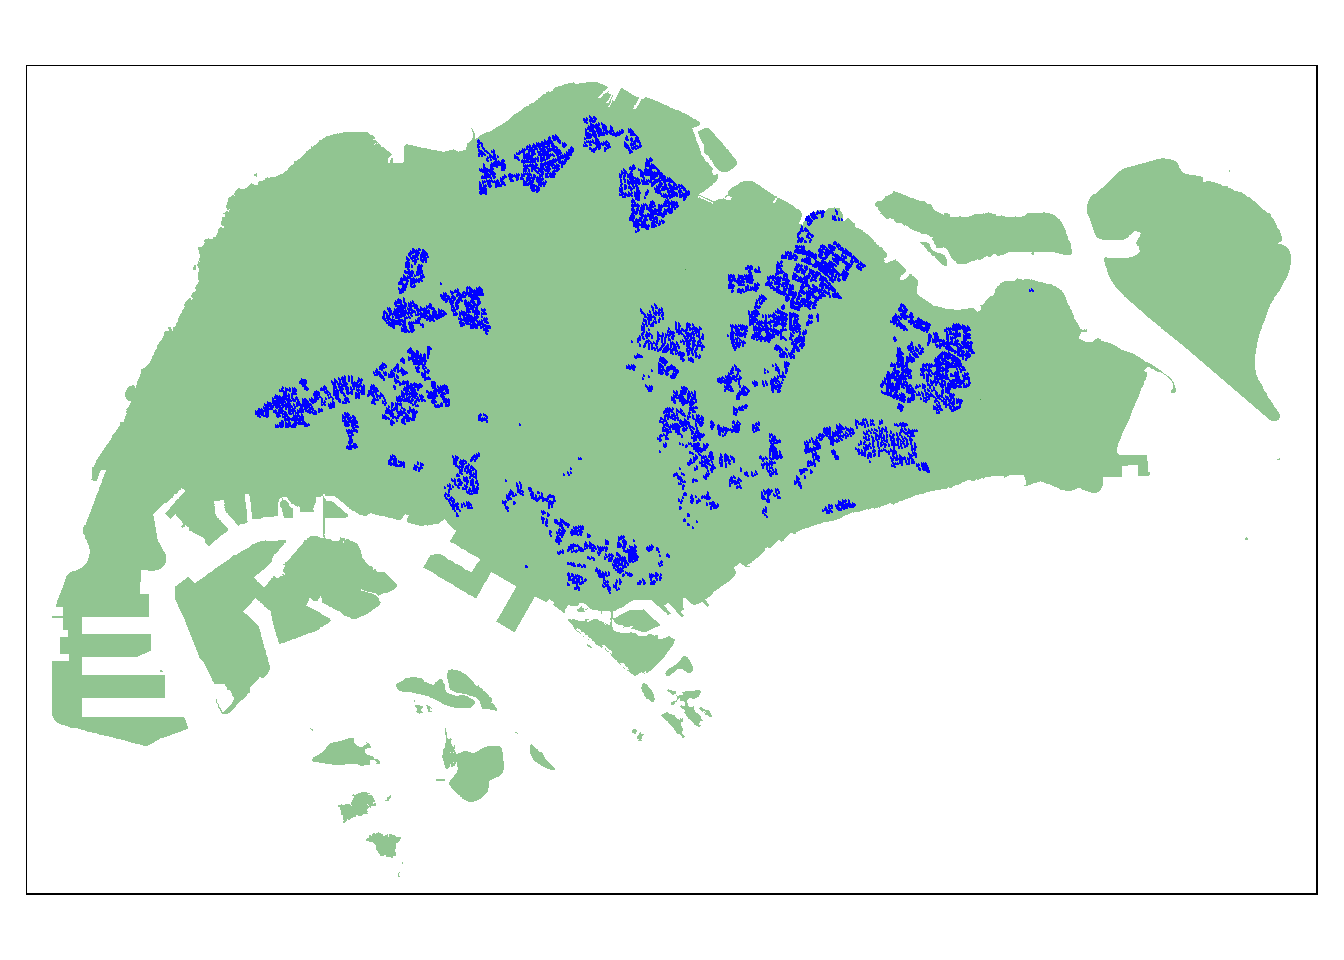

In [ ]:
  tm_shape(mpsz) +
  tm_fill("forestgreen", title = "Singapore Boundary", alpha = 0.5) +
  tm_shape(respop_sf) +
  tm_dots(col = "blue", size = 0.005, title = "Business")

# Creating the Hexagon Layer

In [ ]:
hex_layer <- st_make_grid(mpsz,
               cellsize = 400,
               what = "polygon",
               square = FALSE) %>%
  st_sf() 

hex_layer

Simple feature collection with 13685 features and 0 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 2267.538 ymin: 15517.78 xmax: 56667.54 ymax: 50620.68
Projected CRS: SVY21 / Singapore TM
First 10 features:
                         geometry
1  POLYGON ((2467.538 15864.19...
2  POLYGON ((2467.538 16557.01...
3  POLYGON ((2467.538 17249.83...
4  POLYGON ((2467.538 17942.65...
5  POLYGON ((2467.538 18635.47...
6  POLYGON ((2467.538 19328.29...
7  POLYGON ((2467.538 20021.11...
8  POLYGON ((2467.538 20713.93...
9  POLYGON ((2467.538 21406.75...
10 POLYGON ((2467.538 22099.57...

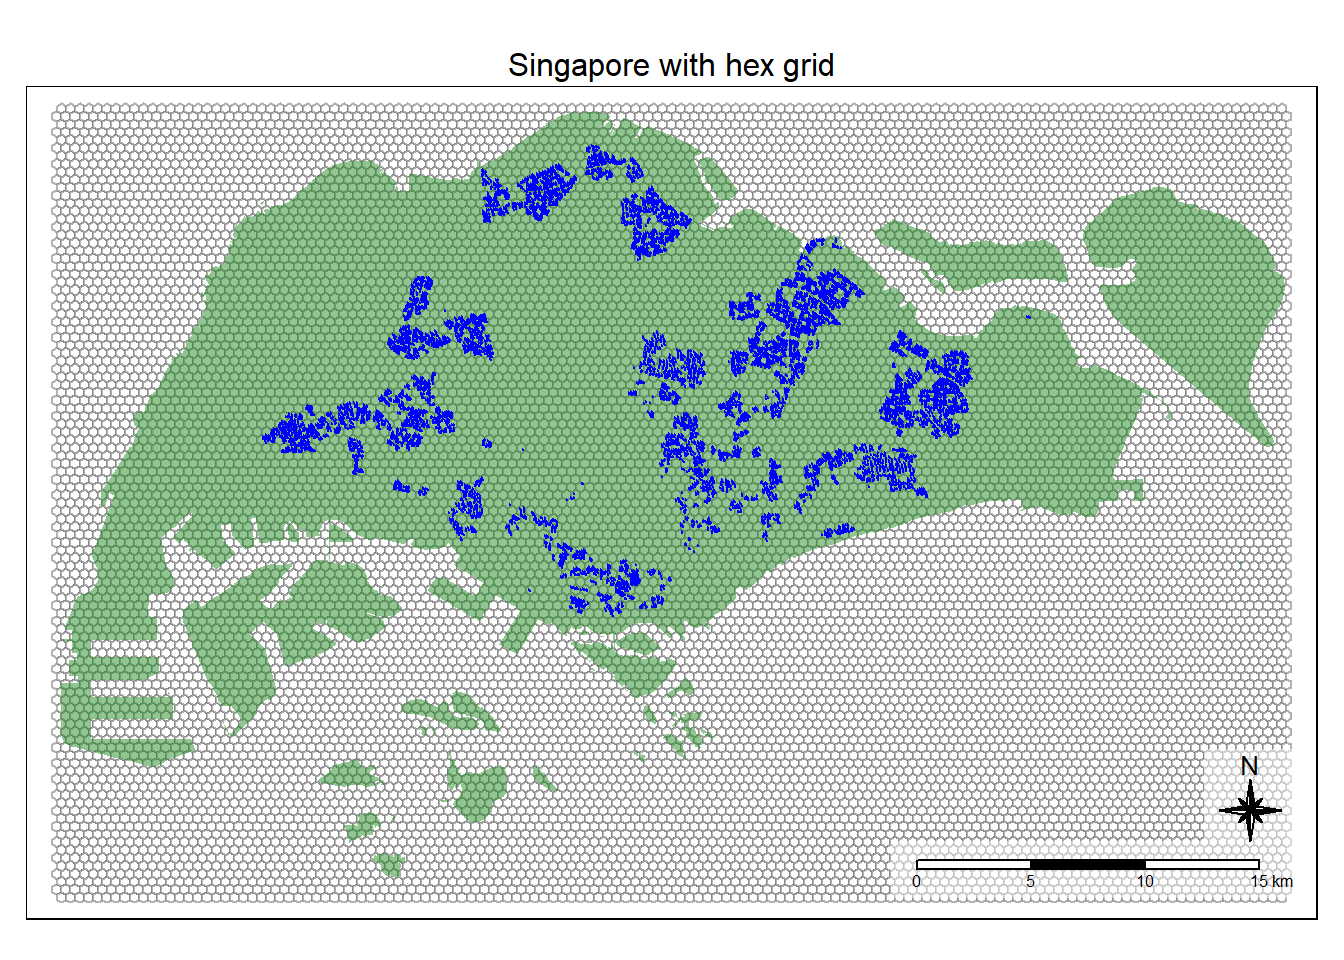

In [ ]:
tm_shape(hex_layer) +
  tm_fill(col = "white", title = "Hexagons") +
  tm_borders(alpha = 0.5) +
  tm_layout(main.title = "Singapore with hex grid",
            main.title.position = "center",
            main.title.size = 1.0,
            legend.height = 0.35, 
            legend.width = 0.35,
            frame = TRUE) +
  tm_compass(type="8star", size = 2, bg.color = "white", bg.alpha = 0.5) +
  tm_scale_bar(bg.color = "white", bg.alpha = 0.5) +
  tm_shape(mpsz) +
  tm_fill("forestgreen", title = "Singapore Boundary", alpha = 0.5) +
  tm_shape(respop_sf) +
  tm_dots(col = "blue", size = 0.005, title = "Business")

## Giving each hexagon an ID

In [ ]:
hex_layer$HEX_ID <- sprintf("H%04d", seq_len(nrow(hex_layer))) %>% as.factor()
head(hex_layer)

Simple feature collection with 6 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 2267.538 ymin: 15864.19 xmax: 2667.538 ymax: 19790.17
Projected CRS: SVY21 / Singapore TM
                        geometry HEX_ID
1 POLYGON ((2467.538 15864.19...  H0001
2 POLYGON ((2467.538 16557.01...  H0002
3 POLYGON ((2467.538 17249.83...  H0003
4 POLYGON ((2467.538 17942.65...  H0004
5 POLYGON ((2467.538 18635.47...  H0005
6 POLYGON ((2467.538 19328.29...  H0006

## Count of HDB blocks in each hexagon

In [ ]:
hex_layer$'HDB_COUNT' <- lengths(st_intersects(hex_layer, respop_sf))

In [ ]:
res_hex <- filter(hex_layer, HDB_COUNT > 0)
res_hex

Simple feature collection with 1030 features and 2 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 11267.54 ymin: 27642.14 xmax: 45467.54 ymax: 48888.63
Projected CRS: SVY21 / Singapore TM
First 10 features:
                         geometry HEX_ID HDB_COUNT
1  POLYGON ((11467.54 35609.57...  H2302         7
2  POLYGON ((11667.54 35263.16...  H2352         1
3  POLYGON ((11667.54 35955.98...  H2353         3
4  POLYGON ((11867.54 35609.57...  H2403        21
5  POLYGON ((12067.54 35955.98...  H2454        19
6  POLYGON ((12267.54 34916.75...  H2503         1
7  POLYGON ((12267.54 35609.57...  H2504         7
8  POLYGON ((12267.54 36302.39...  H2505        11
9  POLYGON ((12467.54 35263.16...  H2554        12
10 POLYGON ((12467.54 35955.98...  H2555        22

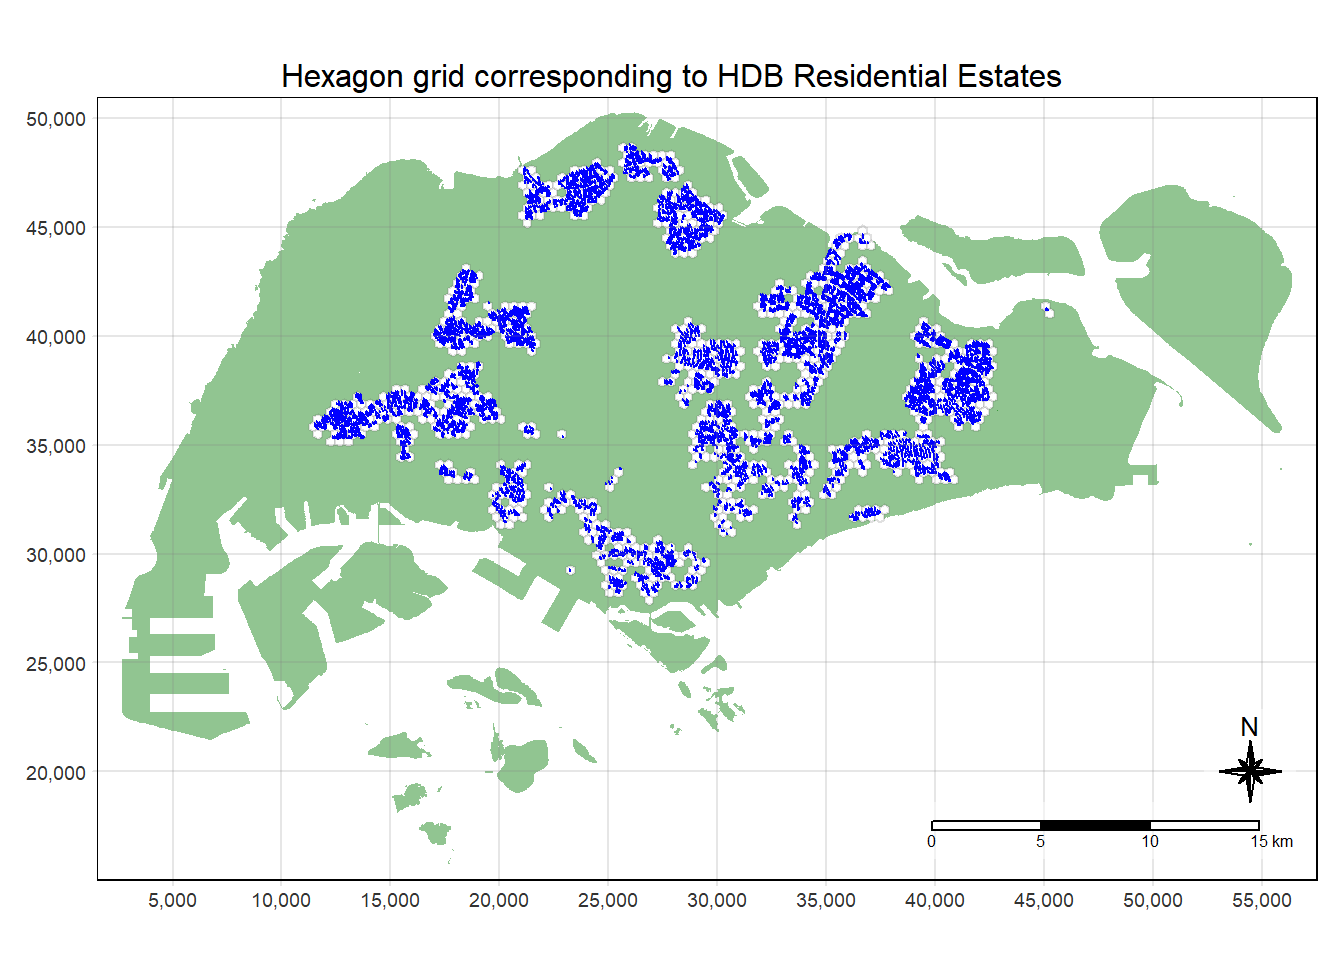

In [ ]:
tm_shape(mpsz) +
  tm_fill("forestgreen", title = "Singapore Boundary", alpha = 0.5) +
  tm_shape(res_hex) +
  tm_fill(col = "white", title = "Hexagons", alpha = 1) +
  tm_borders(alpha = 0.2) +
  tm_layout(main.title = "Hexagon grid corresponding to HDB Residential Estates",
            main.title.position = "center",
            main.title.size = 1.0,
            legend.height = 0.35, 
            legend.width = 0.35,
            frame = TRUE) +
  tm_compass(type="8star", size = 2, bg.color = "white", bg.alpha = 0.5) +
  tm_scale_bar(bg.color = "white", bg.alpha = 0.5) +
  tm_shape(respop_sf) +
  tm_dots(col = "blue", size = 0.001, title = "Bus Stops") +
  tm_grid(alpha = 0.2)

## Sum of Dwellings in each hexagon

First find out which blocks are in which hexagon

In [ ]:
res_hex <- st_intersection(respop_sf, hex_layer) %>%
  st_drop_geometry() %>%
  select(c(postal,total_dwelling_units, HEX_ID))

all geometries

# A tibble: 6 × 3
  postal total_dwelling_units HEX_ID
  <chr>                 <dbl> <fct> 
1 640903                   84 H2302 
2 640904                  110 H2302 
3 640905                   28 H2302 
4 640906                   90 H2302 
5 640907                   77 H2302 
6 640908                  110 H2302 

Aggregate by hexagon

In [ ]:
dwelling_hex <- res_hex %>%
  group_by(HEX_ID) %>%
  summarise(TOTAL_DWELLING = sum(total_dwelling_units))

head(dwelling_hex)

# A tibble: 6 × 2
  HEX_ID TOTAL_DWELLING
  <fct>           <dbl>
1 H10029            736
2 H10030            267
3 H10031            944
4 H10032           1206
5 H10033           1147
6 H10034           1053

## Hexagons only with dwelling

In [ ]:
hex_layer <- left_join(hex_layer, dwelling_hex, by = join_by(HEX_ID))
head(hex_layer)

Simple feature collection with 6 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 2267.538 ymin: 15864.19 xmax: 2667.538 ymax: 19790.17
Projected CRS: SVY21 / Singapore TM
  HEX_ID HDB_COUNT TOTAL_DWELLING                       geometry
1  H0001         0             NA POLYGON ((2467.538 15864.19...
2  H0002         0             NA POLYGON ((2467.538 16557.01...
3  H0003         0             NA POLYGON ((2467.538 17249.83...
4  H0004         0             NA POLYGON ((2467.538 17942.65...
5  H0005         0             NA POLYGON ((2467.538 18635.47...
6  H0006         0             NA POLYGON ((2467.538 19328.29...

In [ ]:
dwell_hex <- filter(hex_layer, TOTAL_DWELLING > 0)
dwell_hex

Simple feature collection with 1030 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 11267.54 ymin: 27642.14 xmax: 45467.54 ymax: 48888.63
Projected CRS: SVY21 / Singapore TM
First 10 features:
   HEX_ID HDB_COUNT TOTAL_DWELLING                       geometry
1   H2302         7            609 POLYGON ((11467.54 35609.57...
2   H2352         1             96 POLYGON ((11667.54 35263.16...
3   H2353         3            175 POLYGON ((11667.54 35955.98...
4   H2403        21           1996 POLYGON ((11867.54 35609.57...
5   H2454        19           1691 POLYGON ((12067.54 35955.98...
6   H2503         1            153 POLYGON ((12267.54 34916.75...
7   H2504         7            790 POLYGON ((12267.54 35609.57...
8   H2505        11            873 POLYGON ((12267.54 36302.39...
9   H2554        12           1243 POLYGON ((12467.54 35263.16...
10  H2555        22           1511 POLYGON ((12467.54 35955.98...

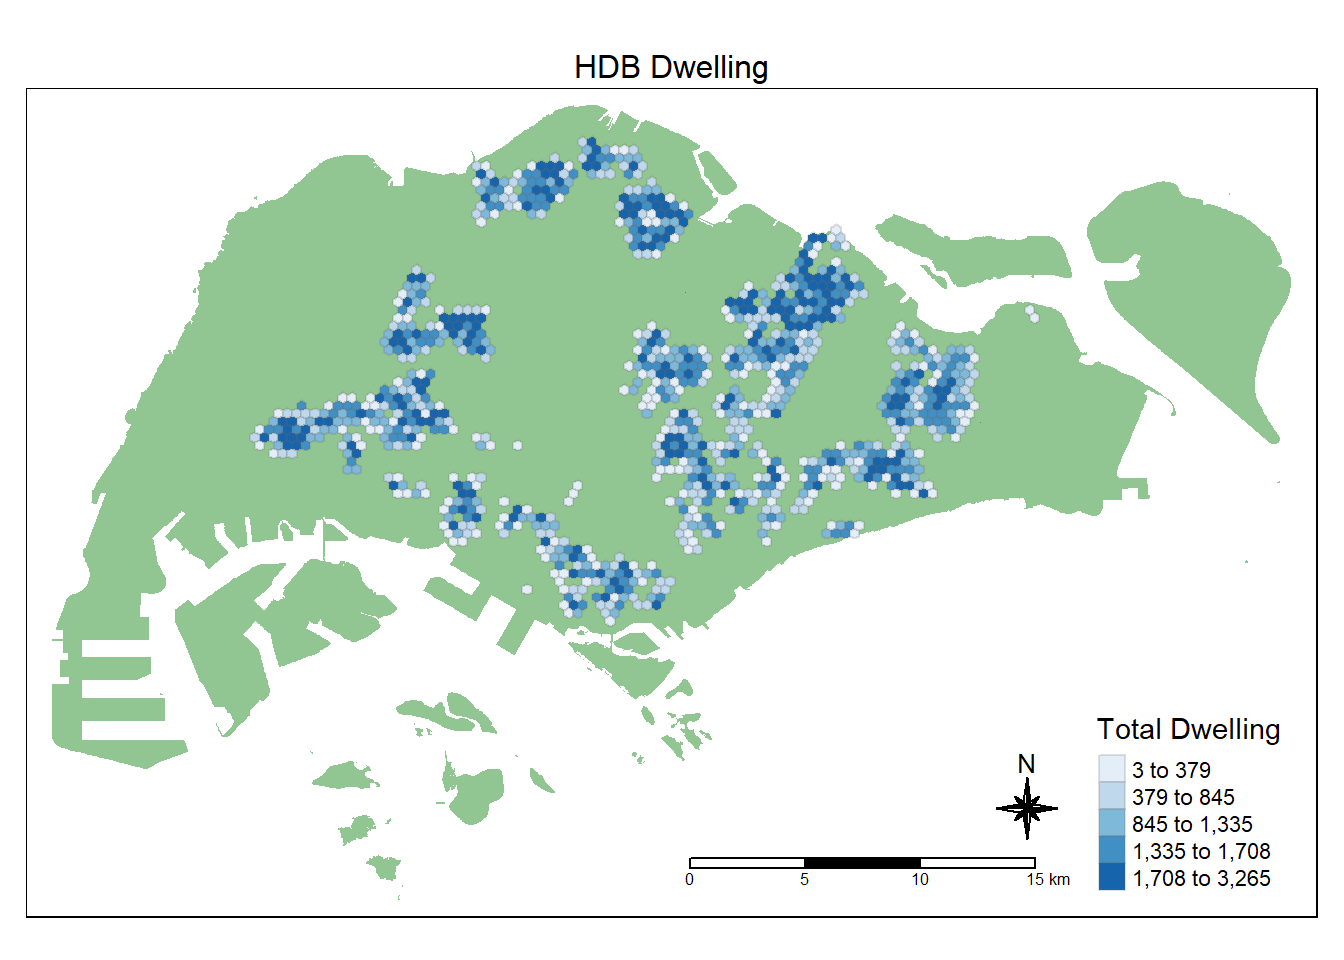

In [ ]:
tm_shape(mpsz) +
  tm_fill("forestgreen", title = "Singapore Boundary", alpha = 0.5) +
  tm_shape(dwell_hex) +
  tm_fill("TOTAL_DWELLING",
          style = "quantile",
          palette = "Blues",
          title = "Total Dwelling") +
  tm_borders(alpha = 0.2) +
  tm_layout(main.title = "HDB Dwelling",
            main.title.position = "center",
            main.title.size = 1.0,
            legend.height = 0.35, 
            legend.width = 0.35,
            frame = TRUE) +
  tm_compass(type="8star", size = 2, bg.color = "white", bg.alpha = 0.5) +
  tm_scale_bar(bg.color = "white", bg.alpha = 0.5) 

# Is there any signs of spatial clustering?

In [ ]:
knn6_nb <- dwell_hex %>% st_centroid() %>% st_knn(k=6)

[[1]]
[1]  2  3  4  5  7 10

[[2]]
[1] 1 3 4 5 6 7

[[3]]
[1] 1 2 4 5 7 8

In [ ]:
dwell_knn6 <- dwell_hex %>%
  mutate(
    nb = knn6_nb,
    wt = st_inverse_distance(nb, geometry,
                             scale = 1,
                             alpha = 1)
  )

! Polygon provided. Using point on surface.

## Global Measure of Spatial Autocorrelation

In [ ]:
global_moran_perm(
  dwell_knn6$TOTAL_DWELLING,
  dwell_knn6$nb,
  dwell_knn6$wt,
  nsim = 99
)


    Monte-Carlo simulation of Moran I

data:  x 
weights: listw  
number of simulations + 1: 100 

statistic = 0.14372, observed rank = 100, p-value < 2.2e-16
alternative hypothesis: two.sided

I is 0.14372, which is more than 0, showing signs of clustering

## Local Measure of Spatial Autocorrelation

### Calculating Local Moran’s I

In [ ]:
lmi_dwell <- dwell_knn6 %>% 
  mutate(local_moran = local_moran(
    TOTAL_DWELLING, nb, wt, nsim = 99),
         .before = 1) %>%
  unnest(local_moran)

### Plotting Local Moran’s I and p-value

Variable(s) "ii" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

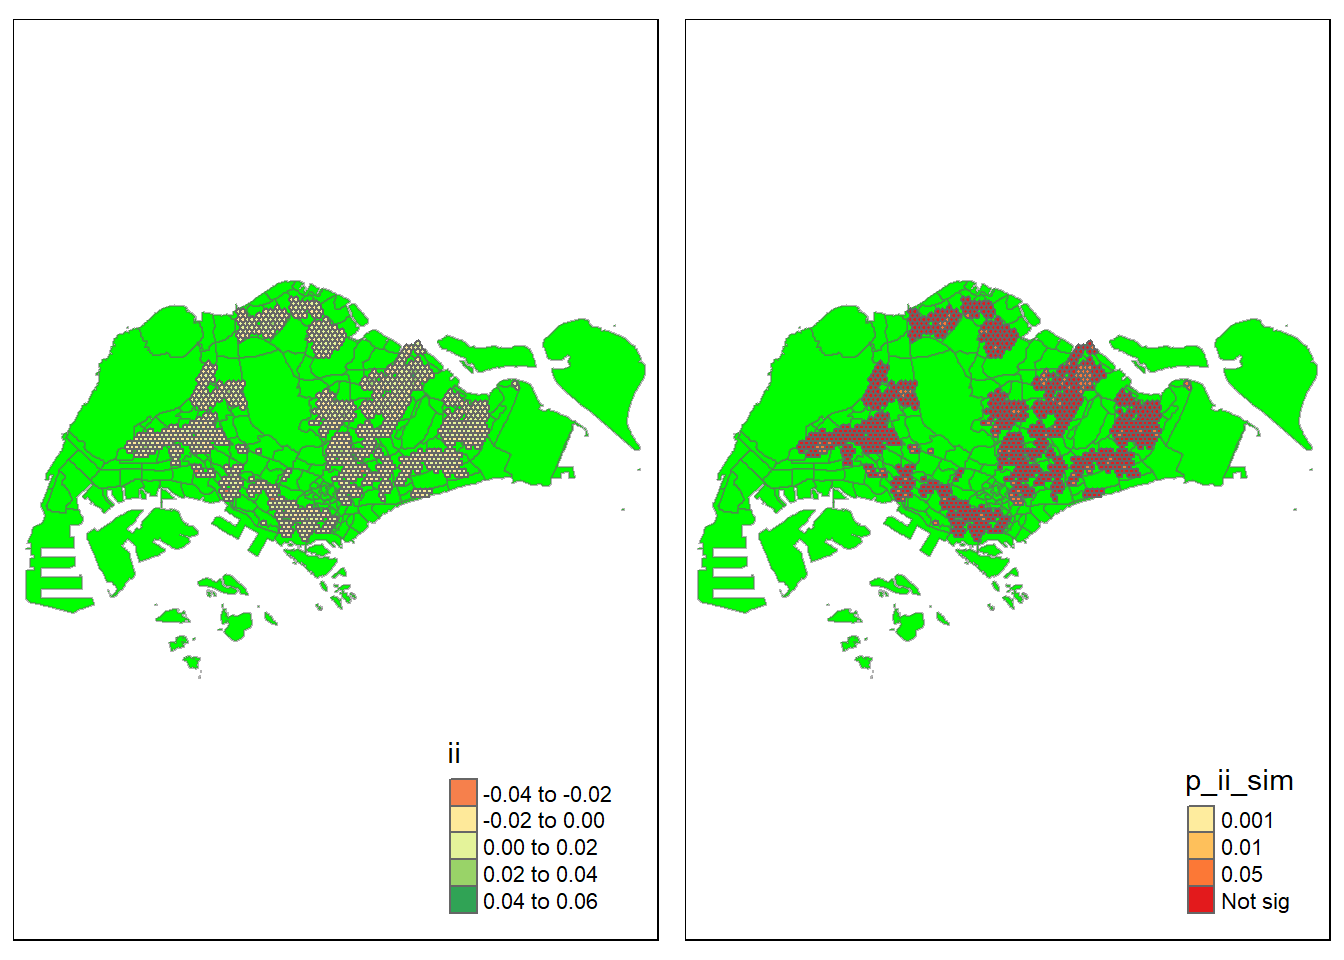

In [ ]:
 tmap_arrange(
    tm_shape(mpsz) +
      tm_fill(col="green") +
      tm_borders(alpha = 0.5) +
      tm_shape(lmi_dwell) +
      tm_polygons("ii"),
    tm_shape(mpsz) +
      tm_fill(col="green") +
      tm_borders(alpha = 0.5) +
      tm_shape(lmi_dwell) +
      tm_polygons("p_ii_sim",
              breaks = c(0, 0.001, 0.01, 0.05, 1),
              labels = c("0.001", "0.01", "0.05", "Not sig"),
              palette = "YlOrRd"
              ),
    ncol = 2
  )

### Plotting LISA Map

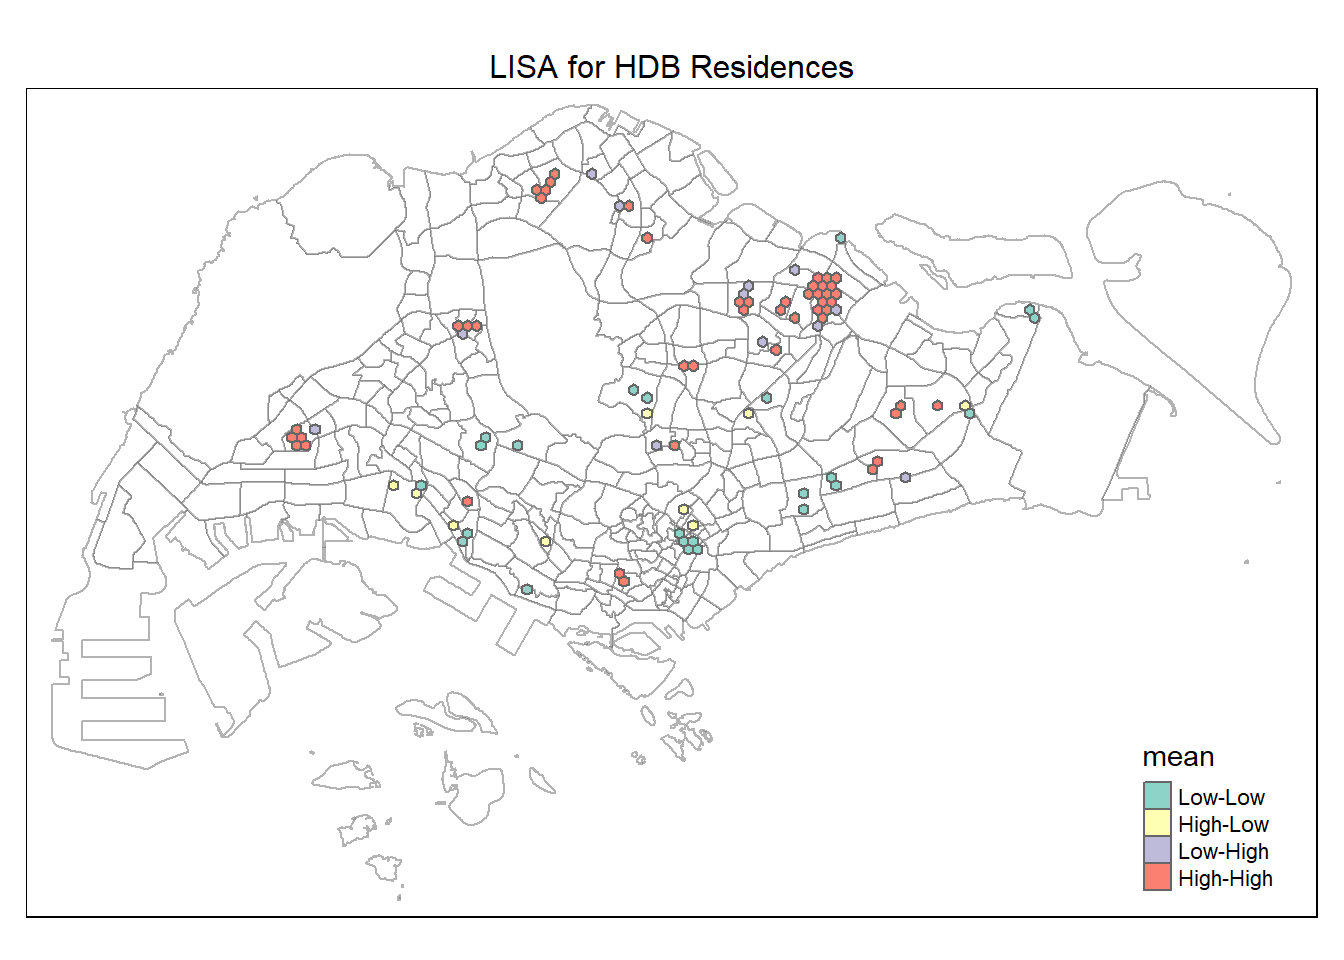

In [ ]:
tm_shape(mpsz) +
  tm_fill(col="white")+
  tm_borders(alpha = 0.5) +
  tm_shape(lmi_dwell %>% filter(p_ii_sim < 0.05)) +
  tm_polygons("mean") + 
  tm_layout(
    main.title = "LISA for HDB Residences",
    main.title.position = "center",
    main.title.size = 1
  )